Index(['DOY', 'HOUR', 'LW_OUT', 'TS_1_1_1', 'TS_1_2_1', 'PPFD', 'Tair', 'VPD',
       'SWC_1_1_1', 'Site', 'PPFD_OUT', 'PPFD_BC_IN_1_1_1', 'Rh', 'NETRAD',
       'Ustar', 'gcc_50', 'rcc_50', 'EVI', 'NDVI', 'Daily Precipitation',
       'prcp1week', 'prcp2week', 'MAT_daymet', 'MAP_daymet', 'LE50', 'PVeg_AG',
       'PVeg_DB', 'PVeg_EB', 'PVeg_EN', 'PVeg_GR', 'PVeg_SH', 'PVeg_TN',
       'SVeg_AG', 'SVeg_DB', 'SVeg_EB', 'SVeg_EN', 'SVeg_GR', 'SVeg_SH',
       'SVeg_TN'],
      dtype='object')
Dataframe Loaded


(array([  1705.,   3764.,  17896., 128297., 278954., 107928.,  82083.,
         51613.,  25968.,   9322.]),
 array([-343.95447045, -268.01378152, -192.07309259, -116.13240365,
         -40.19171472,   35.74897421,  111.68966314,  187.63035208,
         263.57104101,  339.51172994,  415.45241888]),
 <BarContainer object of 10 artists>)

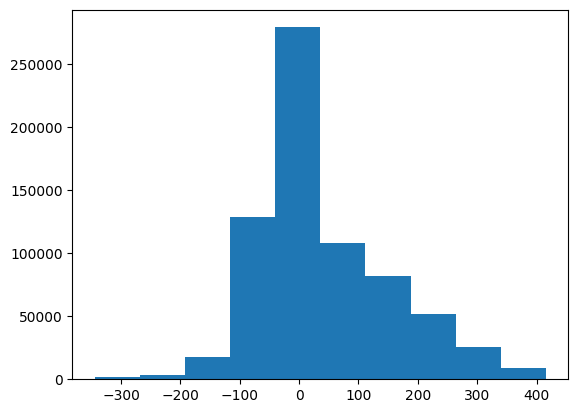

In [12]:
import pandas as pd
import numpy as np
import multiprocessing as mp
import time
import matplotlib.pyplot as plt
import xgboost as xgb
import os
import imblearn
import smogn
from sklearn.neighbors import KernelDensity

from sklearn import tree, preprocessing
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import LearningCurveDisplay, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, LeaveOneGroupOut, RepeatedKFold, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import boxcox, yeojohnson, norm


#Read CSV to pandas dataframe, header first row 
df_chunk=pd.read_csv("/Users/johnleland/Desktop/LE50DataVer_NEW.csv", header = 0, chunksize=10000, low_memory= True)

chunk_list = []  # append each chunk df here 
# Each chunk is in df format
for chunk in df_chunk: 
    
    # Once the data filtering is done, append the chunk to list
    chunk_list.append(chunk)
    
# concat the list into dataframe 
df1 = pd.concat(chunk_list)


print(df1.columns)
print("Dataframe Loaded")

X = df1.drop(["LE50","Site"], axis = 1)
Y = df1["LE50"] # log/ box-cox transform?


plt.hist(Y)

In [16]:
model = xgb.XGBRegressor(objective="reg:squarederror", random_state=13, tree_method = "hist",n_estimators = 2000, early_stopping_rounds = 50, 
                        max_depth=8, learning_rate = 0.015, min_child_weight=1, subsample=0.6, colsample_bynode = 0.6) 

#model = xgb.XGBRegressor(objective="reg:squarederror", random_state=13, tree_method = "hist",n_estimators = 2500, early_stopping_rounds = 50, 
 #                        colsample_bynode =0.45, learning_rate=0.05, max_depth=14, min_child_weight=1, subsample=0.5)
overallmse = []
overallr2 = []
cv = LeaveOneGroupOut()
# cv = KFold(n_splits=10, shuffle=True, random_state=13)
for i, (train, test) in enumerate(cv.split(X, Y, groups = df1["Site"])):
    print("Fold Number:", i)
    start = time.time()

    x_train = X.iloc[train]
    y_train = Y.iloc[train]

    x_test = X.iloc[test]
    y_test = Y.iloc[test]


    # this is for KDE sampling. Ignore that here. 
    #yt = y_train.values.reshape(-1,1)
    #dw = DenseWeight(alpha=10)

    # Fit DenseWeight and get the weights for the 1000 samples
    #weights = dw.fit(yt)  # 

    evalset = [(x_train,y_train),(x_test,y_test)]
    # Model
    model.fit(x_train,y_train, eval_set = evalset, verbose=False)

    #Prediction
    predict2 = model.predict(x_test)

    #Model Assessment
    mse = mean_squared_error(y_test,predict2)
    score = model.score(x_test,y_test)
    overallmse.append(mse)
    overallr2.append(score)
    end = time.time()
    elapsed = end - start
    print("Time Per Fold:", elapsed)
    print(f'MSE: {mse}, R2 Score: {score}')

    """plt.figure(figsize=(10,6))
    #plt.plot(np.multiply(x_test["DOY"].sort_values(),365), y_test, label = "Test")
    #plt.plot(np.multiply(x_test["DOY"].sort_values(),365), predict2, label = "Prediction")

    take average difference over day, group by year? 
    
    plt.plot(y_test-predict2)
    #plt.legend()
    plt.show()"""
print("MSE Average:",np.mean(overallmse), "MSE Median:",np.median(overallmse),"R2 Average:",np.mean(overallr2), "R2 Median:", np.median(overallr2))

Fold Number: 0
Time Per Fold: 6.403818130493164
MSE: 17295.202038866715, R2 Score: 0.15710319181320864
Fold Number: 1
Time Per Fold: 11.183941125869751
MSE: 9153.990332390455, R2 Score: 0.4192346121310795
Fold Number: 2
Time Per Fold: 8.22654390335083
MSE: 2540.410407256372, R2 Score: 0.5798152772439886
Fold Number: 3
Time Per Fold: 8.286600828170776
MSE: 4279.434407908466, R2 Score: 0.35063485586795395
Fold Number: 4
Time Per Fold: 14.570410013198853
MSE: 8348.17833959152, R2 Score: 0.44473906612886993
Fold Number: 5
Time Per Fold: 15.554091930389404
MSE: 5437.175838337067, R2 Score: 0.5332857948149127
Fold Number: 6
Time Per Fold: 11.131977796554565
MSE: 4562.00152574696, R2 Score: 0.45280104142058364
Fold Number: 7
Time Per Fold: 25.512216091156006
MSE: 9023.366899907793, R2 Score: 0.33388030382129796
Fold Number: 8
Time Per Fold: 15.532043695449829
MSE: 7799.617798190077, R2 Score: 0.3727474532339461
Fold Number: 9
Time Per Fold: 28.371161937713623
MSE: 7856.23039883752, R2 Score: 